In [1]:
import sys

sys.path.insert(0, "/nethome/jsteuer/git/lsv/babylm/")

In [2]:
baseline_blimp = 0.731058823529412
baseline_glue = 0.723727272727273
baseline_msgs = 0.809090909090909

In [3]:
from collections import OrderedDict, defaultdict
from copy import copy
import json
import os
from typing import Dict, List

import pandas as pd

import numpy as np


from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

from utils import print_latex_table

In [4]:
from constants import (
    config2size, 
    blimp_tasks, 
    glue_tasks, 
    supplement, 
    msgs_tasks,
    hs2color,
    nlayers2marker
)

In [5]:
RESULTS_PATH = "/local/models/babylm/opt_with_alibi/"

In [6]:
def load_blimp_from_checkpoint(config, seed, run, checkpoints) -> Dict[str, List[float]]:
    
    results = {
        "config": [],
        "seed": [],
        "checkpoint": [],
        "blimp_task": [],
        "accuracy": []
    }
    
    for checkpoint in checkpoints:
        zeroshot_res_path = os.path.join(RESULTS_PATH, config, seed, run, checkpoint, "zeroshot")
        if os.path.exists(zeroshot_res_path):
            for task in blimp_tasks + supplement:
                task_res_path = os.path.join(zeroshot_res_path, task)
                with open(os.path.join(task_res_path, "eval_results.json"), "r") as f:
                    res = json.load(f)
                    results["config"].append(config)
                    results["seed"].append(seed)
                    results["checkpoint"].append(checkpoint)
                    results["blimp_task"].append(task)
                    results["accuracy"].append(res["eval_accuracy"])

    # final model
    zeroshot_res_path = os.path.join(RESULTS_PATH, config, seed, run, "zeroshot")
    if os.path.exists(zeroshot_res_path):
        for task in blimp_tasks + supplement:
            task_res_path = os.path.join(zeroshot_res_path, task)
            with open(os.path.join(task_res_path, "eval_results.json"), "r") as f:
                res = json.load(f)
                results["config"].append(config)
                results["seed"].append(seed)
                results["checkpoint"].append("10000000000")
                results["blimp_task"].append(task)
                results["accuracy"].append(res["eval_accuracy"])

    return results

## BLiMP Results

In [7]:
from constants import blimp_task2color as task2color

In [8]:
dfs = []

for config in os.listdir(RESULTS_PATH):
    config_path = os.path.join(RESULTS_PATH, config)
    for seed in os.listdir(config_path):
        seed_path = os.path.join(config_path, seed)
        run = os.listdir(seed_path)[0]
        results = load_blimp_from_checkpoint(config, seed, run, ["5"])
        df = pd.DataFrame.from_dict(results)
        dfs.append(df)

df_all = pd.concat(dfs)

In [9]:
df_all["hidden_size"] = df_all["config"].str.split("_").str[3].apply(pd.to_numeric)
df_all["layers"] = df_all["config"].str.split("_").str[1].apply(pd.to_numeric)
# df_all["checkpoint"] = df_all["checkpoint"].apply(pd.to_numeric)
df_all["config_short"] = df_all["layers"].astype(str) + "*" + df_all["hidden_size"].astype(str)
# df_all["num_params"] = [config2size[config_short] for config_short in df_all["config_short"]]
# print(df_all["num_params"].unique())
df_all = df_all.sort_values(by=["layers", "hidden_size"], ascending=True)

In [10]:
from constants import config2size

config_by_size = dict(sorted(config2size.items(),key= lambda item: item[1]))
config_by_size = {k: v for k, v in config_by_size.items() if k in df_all["config_short"].unique()}

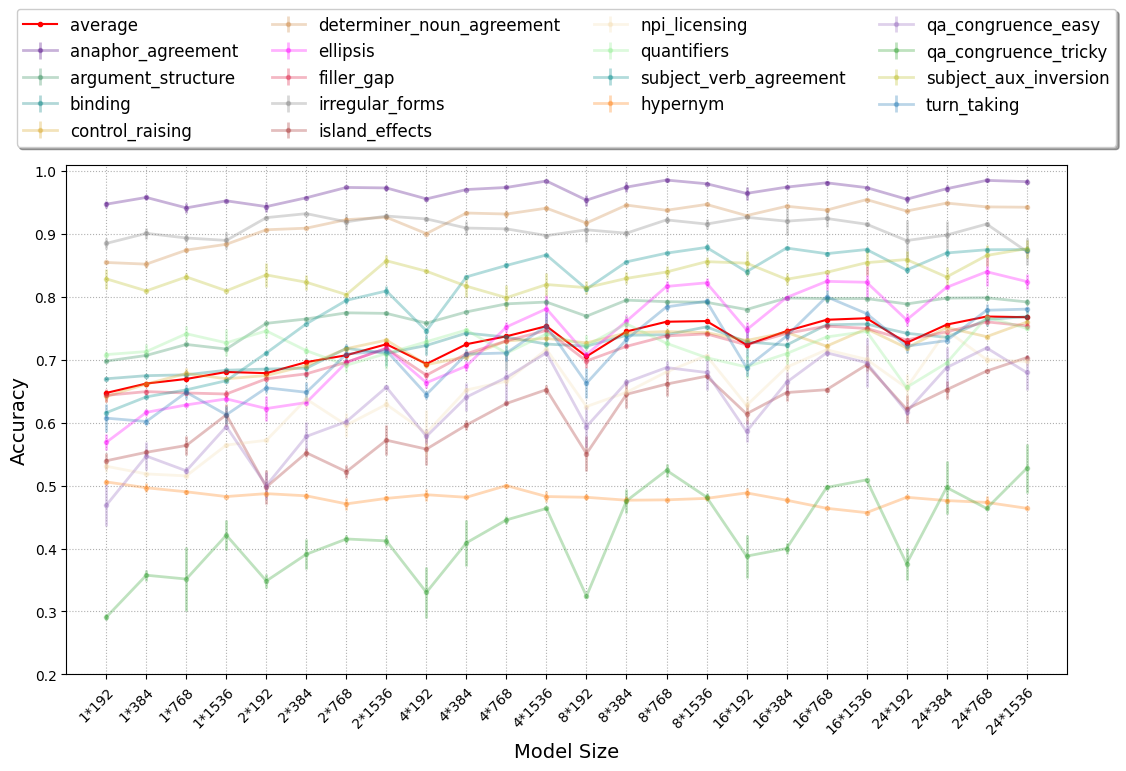

In [11]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

latex_table_content = defaultdict(list)

# results per task
for task in df_all["blimp_task"].unique():
    
    latex_table_content[task] = {}
    acc_avg, acc_se = [], []
    
    for config in df_all["config_short"].unique():
        df = df_all[df_all["blimp_task"]==task]
        df = df[df["config_short"]==config]
        acc_avg.append(np.mean(df["accuracy"]))
        acc_se.append(np.std(df["accuracy"])/np.sqrt(len(df["accuracy"])))
        # ax.plot(i, acc_avg, linestyle="-", color=task2color[task], markersize=3, marker="o", label=task)
        latex_table_field = f"${np.round(acc_avg[-1],2):.2f} \pm {np.round(acc_se[-1],2):.2f}$"
        latex_table_content[task][config] = latex_table_field

    xs = range(len(acc_avg))
    ax.errorbar(xs, acc_avg, acc_se, linestyle="-", linewidth=2.0, color=task2color[task], markersize=6, marker=".", label=task, alpha=0.3)

# average
latex_table_content["average"] = {}
accuracies_avg = {}
for config in df_all["config_short"].unique():
    # overall
    df = df_all[df_all["config_short"]==config]
    acc_avg = np.mean(df["accuracy"])
    acc_se = np.std(df["accuracy"])/np.sqrt(len(df["accuracy"]))
    accuracies_avg[config] = acc_avg
    latex_table_field = f"${np.round(acc_avg,2)} \pm {np.round(acc_se,2)}$"
    latex_table_content["average"][config] = latex_table_field

xs = range(len(accuracies_avg))
ax.plot(xs, list(accuracies_avg.values()), marker=".", label="average", color="red", markerfacecolor="red")

xs = range(0,len(df_all["config_short"].unique()))
ys = np.arange(0,1.01,0.1)

ax.set_xticks(xs, labels=df_all["config_short"].unique(), ha="right", rotation_mode="anchor", rotation=45)
ax.set_yticks(ys)
ax.grid(axis="both", linestyle=":")
ax.set_ylim([0.2,1.01])
ax.set_xlim([-1,24])

plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Model Size", fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.5, 1.17), fontsize=12, loc="center", ncol=4, fancybox=True, shadow=True)

plt.tight_layout();

plt.savefig("../out/img/blimp.png", dpi=400, bbox_inches="tight")

In [12]:
print_latex_table(latex_table_content)

\begin{tabular}{l|c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c }
\hline
\textbf{Task} & \textbf{1*192} & \textbf{1*384} & \textbf{1*768} & \textbf{1*1536} & \textbf{2*192} & \textbf{2*384} & \textbf{2*768} & \textbf{2*1536} & \textbf{4*192} & \textbf{4*384} & \textbf{4*768} & \textbf{4*1536} & \textbf{8*192} & \textbf{8*384} & \textbf{8*768} & \textbf{8*1536} & \textbf{16*192} & \textbf{16*384} & \textbf{16*768} & \textbf{16*1536} & \textbf{24*192} & \textbf{24*384} & \textbf{24*768} & \textbf{24*1536} \\
\hline\hline
anaphor-agreement & $0.95 \pm 0.01$ & $0.96 \pm 0.00$ & $0.94 \pm 0.01$ & $0.95 \pm 0.00$ & $0.94 \pm 0.01$ & $0.96 \pm 0.00$ & $0.97 \pm 0.00$ & $0.97 \pm 0.00$ & $0.96 \pm 0.00$ & $0.97 \pm 0.00$ & $0.97 \pm 0.00$ & $0.98 \pm 0.00$ & $0.95 \pm 0.01$ & $0.97 \pm 0.01$ & $0.99 \pm 0.00$ & $0.98 \pm 0.00$ & $0.96 \pm 0.01$ & $0.97 \pm 0.00$ & $0.98 \pm 0.00$ & $0.97 \pm 0.00$ & $0.96 \pm 0.01$ & $0.97 \pm 0.01$ & $0.98 \pm 0.00$ & $0.98 \pm 0.0

In [13]:
acc_by_config = {config: accuracies_avg[config] for config in config_by_size}
acc_by_size = {config: acc_by_config[config] for config in config_by_size}
df_all["num_params"] = [config2size[config_short] for config_short in df_all["config_short"]]

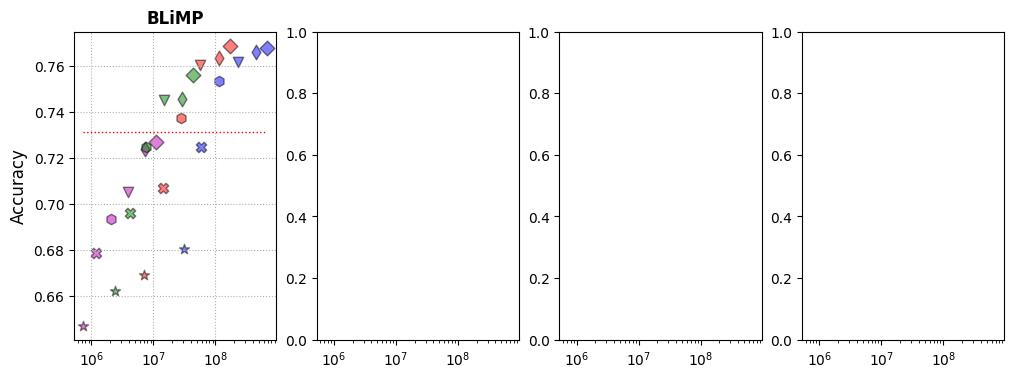

In [14]:
fig_acc_by_size, ((ax_blimp, ax_glue, ax_msgs, ax_rts)) = plt.subplots(
    nrows=1, 
    ncols=4, 
    # sharey=True,
    sharex=True, 
    figsize=(12, 4)
)

# ax2 = ax.twinx()

xs = range(0,len(acc_by_config))

for x, (config, size) in enumerate(config_by_size.items()):
    acc_avg = acc_by_config[config]
    nlayers, hs = config.split("*")[0], config.split("*")[-1]

    ax_blimp.scatter(size, acc_avg, label="model size", 
                     marker=nlayers2marker[nlayers], s=56, color=hs2color[hs],
                     edgecolors=["black"], alpha=0.5)
# ax2.plot(xs, list(acc_by_size.values()), label="BLiMP accuracy", color="r", alpha=0.2, linestyle=":")

# baseline
ax_blimp.plot(list(config_by_size.values()), 
              [baseline_blimp for _ in range(len(xs))], 
              linestyle=":", color="r", linewidth=1)

# regression line over accuracies
# coef = np.polyfit(xs, np.array(list(acc_by_size.values())), 1)
# poly1d_fn = np.poly1d(coef)

# ax.plot(xs, poly1d_fn(xs), color="r")

ax_blimp.set_title("BLiMP", weight='bold', fontsize=12)

ax_blimp.set_xscale("log")
# ax.set_facecolor("#eafff5")
# ax_blimp.set_facecolor("#D5F5E3")

ax_blimp.set_ylabel("Accuracy", fontsize=12)

# plt.tight_layout();

ax_blimp.grid(axis="both", linestyle=":")

In [15]:
# save final dataframe
df_blimp = copy(df_all)
df_blimp.to_csv("../out/results_blimp.tsv", sep="\t", index=0)

## GLUE Results

In [16]:
RESULTS_PATH = "/local/models/babylm/opt_with_alibi/"

In [17]:
from constants import glue_task2color as task2color

In [18]:
def load_glue_from_checkpoint(config, seed, run, checkpoints):
    results = {
        "config": [],
        "seed": [],
        "checkpoint": [],
        "glue_task": [],
        "accuracy": []
    }
    for checkpoint in checkpoints:
        finetune_res_path = os.path.join(RESULTS_PATH, config, seed, run, checkpoint, "finetune")
        if os.path.exists(finetune_res_path):
            for task in glue_tasks:
                task_res_file = os.path.join(finetune_res_path, task, "eval_results.json")
                if os.path.exists(task_res_file):
                    with open(os.path.join(task_res_file), "r") as f:
                        res = json.load(f)
                        results["config"].append(config)
                        results["seed"].append(seed)
                        results["checkpoint"].append(checkpoint)
                        results["glue_task"].append(task)
                        results["accuracy"].append(res["eval_accuracy"])
                else:
                    print(f"Skipping {config}/{seed}/{run}/{checkpoint}/finetune/{task}")
    
    # final model
    finetune_res_path = os.path.join(RESULTS_PATH, config, seed, run, "finetune")
    if os.path.exists(finetune_res_path):
        for task in glue_tasks:
            task_res_file = os.path.join(finetune_res_path, task, "eval_results.json")
            if os.path.exists(task_res_file):
                with open(os.path.join(task_res_file), "r") as f:
                    res = json.load(f)
                    print(res)
                    results["config"].append(config)
                    results["seed"].append(seed)
                    results["checkpoint"].append(checkpoint)
                    results["glue_task"].append(task)
                    results["accuracy"].append(res["eval_accuracy"])
            else:
                print(f"Skipping {config}/{seed}/{run}/finetune/{task}")
    
    return results

In [19]:
dfs = []

for config in os.listdir(RESULTS_PATH):
    config_path = os.path.join(RESULTS_PATH, config)
    for seed in os.listdir(config_path):
        seed_path = os.path.join(config_path, seed)
        run = os.listdir(seed_path)[0]
        results = load_glue_from_checkpoint(config, seed, run, ["5"])
        df = pd.DataFrame.from_dict(results)
        dfs.append(df)

print(len(dfs))

df_all = pd.concat(dfs)

Skipping layers_1_hs_192_heads_12_cl_256/13/run_2023-06-30-08-48-01/5/finetune/boolq
Skipping layers_1_hs_192_heads_12_cl_256/13/run_2023-06-30-08-48-01/5/finetune/cola
Skipping layers_1_hs_192_heads_12_cl_256/13/run_2023-06-30-08-48-01/5/finetune/mnli
Skipping layers_1_hs_192_heads_12_cl_256/13/run_2023-06-30-08-48-01/5/finetune/mnli-mm
Skipping layers_1_hs_192_heads_12_cl_256/13/run_2023-06-30-08-48-01/5/finetune/mrpc
Skipping layers_1_hs_192_heads_12_cl_256/13/run_2023-06-30-08-48-01/5/finetune/multirc
Skipping layers_1_hs_192_heads_12_cl_256/13/run_2023-06-30-08-48-01/5/finetune/qnli
Skipping layers_1_hs_192_heads_12_cl_256/13/run_2023-06-30-08-48-01/5/finetune/qqp
Skipping layers_1_hs_192_heads_12_cl_256/13/run_2023-06-30-08-48-01/5/finetune/rte
Skipping layers_1_hs_192_heads_12_cl_256/13/run_2023-06-30-08-48-01/5/finetune/sst2
Skipping layers_1_hs_192_heads_12_cl_256/13/run_2023-06-30-08-48-01/5/finetune/wsc
Skipping layers_1_hs_384_heads_12_cl_256/13/run_2023-06-30-14-00-33/5/fi

In [20]:
df_all["hidden_size"] = df_all["config"].str.split("_").str[3].apply(pd.to_numeric)
df_all["layers"] = df_all["config"].str.split("_").str[1].apply(pd.to_numeric)
# df_all["checkpoint"] = df_all["checkpoint"].apply(pd.to_numeric)
df_all["config_short"] = df_all["layers"].astype(str) + "*" + df_all["hidden_size"].astype(str)
# df_all["num_params"] = [config2size[config_short] for config_short in df_all["config_short"]]
# print(df_all["num_params"].unique())
df_all = df_all.sort_values(by=["layers", "hidden_size"], ascending=True)

In [21]:
print(df_all["config_short"].unique())

['1*192' '1*384' '1*768' '1*1536' '2*192' '2*384' '2*768' '2*1536' '4*192'
 '4*384' '4*768' '4*1536' '8*192' '8*384' '8*768' '8*1536' '16*192'
 '16*384' '16*768' '16*1536' '24*192' '24*384' '24*768' '24*1536']


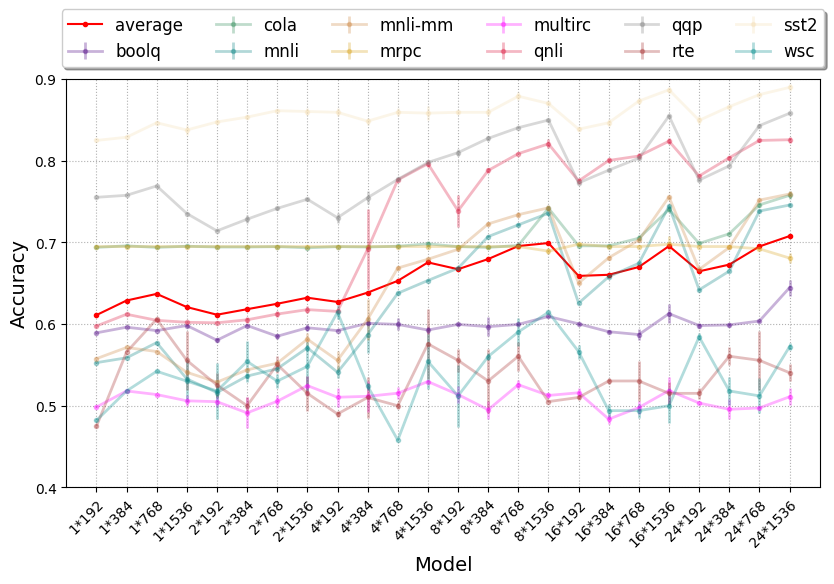

In [22]:
fig = plt.figure(figsize=(8.8,6))
ax = fig.add_subplot(111)

latex_table_content = defaultdict(list)

# results per task
for task in df_all["glue_task"].unique():
    
    latex_table_content[task] = {}
    acc_avg, acc_se = [], []
    
    for config in df_all["config_short"].unique():
        df = df_all[df_all["glue_task"]==task]
        df = df[df["config_short"]==config]
        # print(i, config, task, np.mean(df["accuracy"]))
        acc_avg.append(np.mean(df["accuracy"]))
        acc_se.append(np.std(df["accuracy"])/np.sqrt(len(df["accuracy"])))
        # ax.plot(i, acc_avg, linestyle="-", color=task2color[task], markersize=3, marker="o", label=task)
        latex_table_field = f"${np.round(acc_avg[-1],2):.2f} \pm {np.round(acc_se[-1],2):.2f}$"
        latex_table_content[task][config] = latex_table_field
        
    xs = range(len(acc_avg))
    ax.errorbar(xs, acc_avg, acc_se, linestyle="-", linewidth=2.0, color=task2color[task], markersize=6, marker=".", label=task, alpha=0.3)

# average
latex_table_content["average"] = {}
accuracies_avg = {}
for config in df_all["config_short"].unique():
    # overall
    df = df_all[df_all["config_short"]==config]
    acc_avg = np.mean(df["accuracy"])
    acc_se = np.std(df["accuracy"])/np.sqrt(len(df["accuracy"]))
    accuracies_avg[config] = acc_avg
    latex_table_field = f"${np.round(acc_avg,2)} \pm {np.round(acc_se,2)}$"
    latex_table_content["average"][config] = latex_table_field

xs = range(len(accuracies_avg))
ax.plot(xs, list(accuracies_avg.values()), marker=".", label="average", color="red", markerfacecolor="red")

xs = range(0,len(df_all["config_short"].unique()))
ys = np.arange(0,1.01,0.1)

ax.set_xticks(xs, labels=accuracies_avg.keys(), ha="right", rotation_mode="anchor", rotation=45)
ax.set_yticks(ys)
ax.grid(axis="both", linestyle=":")
ax.set_ylim([0.4,0.9])
ax.set_xlim([-1,24])

plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Model", fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.5, 1.1), fontsize=12, loc="center", ncol=6, fancybox=True, shadow=True)

plt.tight_layout();

plt.savefig("../out/img/glue.png", dpi=400, bbox_inches="tight")

In [23]:
print_latex_table(latex_table_content)

\begin{tabular}{l|c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c }
\hline
\textbf{Task} & \textbf{1*192} & \textbf{1*384} & \textbf{1*768} & \textbf{1*1536} & \textbf{2*192} & \textbf{2*384} & \textbf{2*768} & \textbf{2*1536} & \textbf{4*192} & \textbf{4*384} & \textbf{4*768} & \textbf{4*1536} & \textbf{8*192} & \textbf{8*384} & \textbf{8*768} & \textbf{8*1536} & \textbf{16*192} & \textbf{16*384} & \textbf{16*768} & \textbf{16*1536} & \textbf{24*192} & \textbf{24*384} & \textbf{24*768} & \textbf{24*1536} \\
\hline\hline
boolq & $0.59 \pm 0.00$ & $0.60 \pm 0.00$ & $0.59 \pm 0.00$ & $0.60 \pm 0.00$ & $0.58 \pm 0.00$ & $0.60 \pm 0.00$ & $0.59 \pm 0.00$ & $0.60 \pm 0.00$ & $0.59 \pm 0.00$ & $0.60 \pm 0.00$ & $0.60 \pm 0.01$ & $0.59 \pm 0.00$ & $0.60 \pm 0.00$ & $0.60 \pm 0.01$ & $0.60 \pm 0.00$ & $0.61 \pm 0.00$ & $0.60 \pm 0.00$ & $0.59 \pm 0.00$ & $0.59 \pm 0.01$ & $0.61 \pm 0.01$ & $0.60 \pm 0.00$ & $0.60 \pm 0.00$ & $0.60 \pm 0.00$ & $0.64 \pm 0.01$ \\
cola &

In [24]:
acc_by_config = {config: accuracies_avg[config] for config in config_by_size if config in accuracies_avg}
acc_by_size = {config: acc_by_config[config] for config in config_by_size if config in accuracies_avg}
df_all["num_params"] = [config2size[config_short] for config_short in df_all["config_short"]]

In [25]:
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111)

# ax2 = ax.twinx()

xs = range(0,len(acc_by_config))

for x, (config, size) in enumerate(config_by_size.items()):

    if config in acc_by_config:
        acc_avg = acc_by_config[config]
        nlayers, hs = config.split("*")[0], config.split("*")[-1]
        ax_glue.scatter(size, acc_avg, label="model size", marker=nlayers2marker[nlayers], 
                        s=56, color=hs2color[hs], edgecolors=["black"],
                        alpha=0.5)

# ax2.plot(xs, list(acc_by_size.values()), label="BLiMP accuracy", color="r", alpha=0.2, linestyle=":")

# baseline
ax_glue.plot(list(config_by_size.values()), 
              [baseline_glue for _ in range(len(xs))], 
              linestyle=":", color="r", linewidth=1)

# regression line over accuracies
# coef = np.polyfit(xs, np.array(list(acc_by_size.values())), 1)
# poly1d_fn = np.poly1d(coef)

# ax.plot(xs, poly1d_fn(xs), color="r")

ax_glue.set_xscale("log")
# ax.set_facecolor("#eafff5")
# ax_glue.set_facecolor("#D5F5E3")

ax_glue.grid(axis="both", linestyle=":")

ax_glue.set_title("GLUE", weight='bold', fontsize=12)

ax_glue.set_ylabel("Accuracy", fontsize=12)

# plt.tight_layout();

Text(279.483695652174, 0.5, 'Accuracy')

In [26]:
# save final dataframe
df_glue = copy(df_all)
df_glue.to_csv("../out/results_glue.tsv", sep="\t", index=0)

## MSGS Results

In [27]:
from constants import msgs_task2color as task2color

In [28]:
def load_msgs_from_checkpoint(config, seed, run, checkpoints):
    results = {
        "config": [],
        "seed": [],
        "checkpoint": [],
        "msgs_task": [],
        "accuracy": []
    }
    for checkpoint in checkpoints:
        finetune_res_path = os.path.join(RESULTS_PATH, config, seed, run, checkpoint, "finetune")
        if os.path.exists(finetune_res_path):
            for task in msgs_tasks:
                task_res_file = os.path.join(finetune_res_path, task, "eval_results.json")
                if os.path.exists(task_res_file):
                    with open(os.path.join(task_res_file), "r") as f:
                        res = json.load(f)
                        results["config"].append(config)
                        results["seed"].append(seed)
                        results["checkpoint"].append(checkpoint)
                        results["msgs_task"].append(task)
                        results["accuracy"].append(res["eval_accuracy"])
                else:
                    print(f"Skipping {config}/{seed}/{run}/{checkpoint}/finetune/{task}")
    
    # final model
    finetune_res_path = os.path.join(RESULTS_PATH, config, seed, run, "finetune")
    if os.path.exists(finetune_res_path):
        for task in msgs_tasks:
            task_res_file = os.path.join(finetune_res_path, task, "eval_results.json")
            if os.path.exists(task_res_file):
                with open(os.path.join(task_res_file), "r") as f:
                    res = json.load(f)
                    print(res)
                    results["config"].append(config)
                    results["seed"].append(seed)
                    results["checkpoint"].append(checkpoint)
                    results["msgs_task"].append(task)
                    results["accuracy"].append(res["eval_accuracy"])
            else:
                print(f"Skipping {config}/{seed}/{run}/finetune/{task}")
    
    return results

In [29]:
dfs = []

for config in os.listdir(RESULTS_PATH):
    config_path = os.path.join(RESULTS_PATH, config)
    for seed in os.listdir(config_path):
        seed_path = os.path.join(config_path, seed)
        run = os.listdir(seed_path)[0]
        results = load_msgs_from_checkpoint(config, seed, run, ["5"])
        df = pd.DataFrame.from_dict(results)
        if len(df) > 0:
            dfs.append(df)

print(len(dfs))

df_all = pd.concat(dfs)

Skipping layers_24_hs_1536_heads_12_cl_256/13/run_2023-07-01-05-17-06/5/finetune/relative_position_control
48


In [30]:
df_all["hidden_size"] = df_all["config"].str.split("_").str[3].apply(pd.to_numeric)
df_all["layers"] = df_all["config"].str.split("_").str[1].apply(pd.to_numeric)
# df_all["checkpoint"] = df_all["checkpoint"].apply(pd.to_numeric)
df_all["config_short"] = df_all["layers"].astype(str) + "*" + df_all["hidden_size"].astype(str)
# df_all["num_params"] = [config2size[config_short] for config_short in df_all["config_short"]]
# print(df_all["num_params"].unique())
df_all = df_all.sort_values(by=["layers", "hidden_size"], ascending=True)

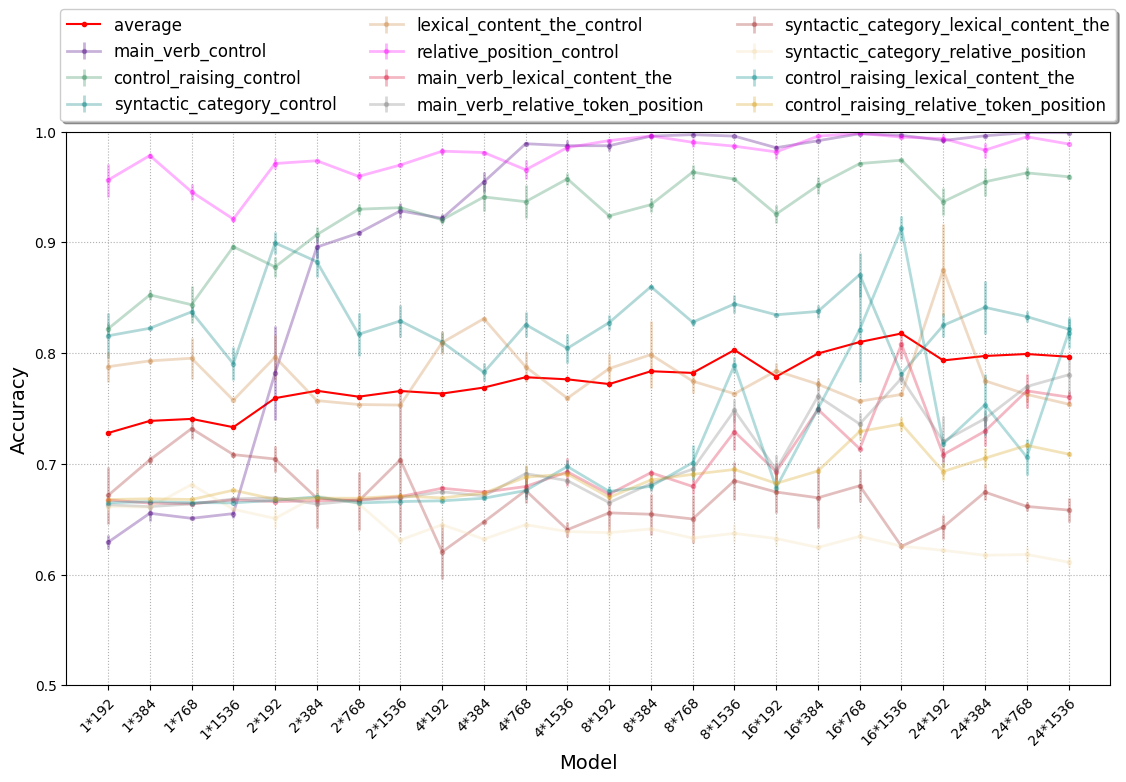

In [31]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

latex_table_content = defaultdict(list)

# results per task
for task in df_all["msgs_task"].unique():

    latex_table_content[task] = {}
    acc_avg, acc_se = [], []
    
    for config in df_all["config_short"].unique():
        df = df_all[df_all["msgs_task"]==task]
        df = df[df["config_short"]==config]
        # print(i, config, task, np.mean(df["accuracy"]))
        acc_avg.append(np.mean(df["accuracy"]))
        acc_se.append(np.std(df["accuracy"])/np.sqrt(len(df["accuracy"])))
        # ax.plot(i, acc_avg, linestyle="-", color=task2color[task], markersize=3, marker="o", label=task)
        latex_table_field = f"${np.round(acc_avg[-1],2):.2f} \pm {np.round(acc_se[-1],2):.2f}$"
        latex_table_content[task][config] = latex_table_field
    
    xs = range(len(acc_avg))
    ax.errorbar(xs, acc_avg, acc_se, linestyle="-", linewidth=2.0, color=task2color[task], markersize=6, marker=".", label=task, alpha=0.3)

# average
latex_table_content["average"] = {}
accuracies_avg = {}
for config in df_all["config_short"].unique():
    # overall
    df = df_all[df_all["config_short"]==config]
    acc_avg = np.mean(df["accuracy"])
    acc_se = np.std(df["accuracy"])/np.sqrt(len(df["accuracy"]))
    accuracies_avg[config] = acc_avg
    latex_table_field = f"${np.round(acc_avg,2)} \pm {np.round(acc_se,2)}$"
    latex_table_content["average"][config] = latex_table_field

xs = range(len(accuracies_avg))
ax.plot(xs, list(accuracies_avg.values()), marker=".", label="average", color="red", markerfacecolor="red")

xs = range(0,len(df_all["config_short"].unique()))
ys = np.arange(0,1.01,0.1)

ax.set_xticks(xs, labels=accuracies_avg.keys(), ha="right", rotation_mode="anchor", rotation=45)
ax.set_yticks(ys)
ax.grid(axis="both", linestyle=":")
ax.set_ylim([0.5,1.0])
ax.set_xlim([-1,24])

plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Model", fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.5, 1.12), fontsize=12, loc="center", ncol=3, fancybox=True, shadow=True)

plt.tight_layout();

plt.savefig("../out/img/glue.png", dpi=400, bbox_inches="tight")

In [32]:
print_latex_table(latex_table_content)

\begin{tabular}{l|c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c  c }
\hline
\textbf{Task} & \textbf{1*192} & \textbf{1*384} & \textbf{1*768} & \textbf{1*1536} & \textbf{2*192} & \textbf{2*384} & \textbf{2*768} & \textbf{2*1536} & \textbf{4*192} & \textbf{4*384} & \textbf{4*768} & \textbf{4*1536} & \textbf{8*192} & \textbf{8*384} & \textbf{8*768} & \textbf{8*1536} & \textbf{16*192} & \textbf{16*384} & \textbf{16*768} & \textbf{16*1536} & \textbf{24*192} & \textbf{24*384} & \textbf{24*768} & \textbf{24*1536} \\
\hline\hline
main-verb-control & $0.63 \pm 0.01$ & $0.66 \pm 0.01$ & $0.65 \pm 0.00$ & $0.66 \pm 0.00$ & $0.78 \pm 0.04$ & $0.90 \pm 0.01$ & $0.91 \pm 0.00$ & $0.93 \pm 0.01$ & $0.92 \pm 0.00$ & $0.95 \pm 0.01$ & $0.99 \pm 0.00$ & $0.99 \pm 0.00$ & $0.99 \pm 0.00$ & $1.00 \pm 0.00$ & $1.00 \pm 0.00$ & $1.00 \pm 0.00$ & $0.99 \pm 0.00$ & $0.99 \pm 0.00$ & $1.00 \pm 0.00$ & $1.00 \pm 0.00$ & $0.99 \pm 0.00$ & $1.00 \pm 0.00$ & $1.00 \pm 0.00$ & $1.00 \pm 0.0

In [33]:
acc_by_config = {config: accuracies_avg[config] for config in config_by_size if config in accuracies_avg}
acc_by_size = {config: acc_by_config[config] for config in config_by_size if config in accuracies_avg}
df_all["num_params"] = [config2size[config_short] for config_short in df_all["config_short"]]

In [34]:
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111)

# ax2 = ax.twinx()

xs = range(0,len(acc_by_config))

for x, (config, size) in enumerate(config_by_size.items()):

    if config in acc_by_config:
        acc_avg = acc_by_config[config]
        nlayers, hs = config.split("*")[0], config.split("*")[-1]
        ax_msgs.scatter(size, acc_avg, label="model size", marker=nlayers2marker[nlayers], s=56, 
                        color=hs2color[hs], edgecolors=["black"],
                        alpha=0.5)
# ax2.plot(xs, list(acc_by_size.values()), label="BLiMP accuracy", color="r", alpha=0.2, linestyle=":")

# baseline
ax_msgs.plot(list(config_by_size.values()), 
              [baseline_msgs for _ in range(len(xs))], 
              linestyle=":", color="r", linewidth=1)

# regression line over accuracies
coef = np.polyfit(xs, np.array(list(acc_by_size.values())), 1)
poly1d_fn = np.poly1d(coef)

# ax.plot(xs, poly1d_fn(xs), color="r")

ax_msgs.set_xscale("log")
# ax.set_facecolor("#eafff5")
# ax_msgs.set_facecolor("#D5F5E3")

ax_msgs.grid(axis="both", linestyle=":")

ax_msgs.set_title("MSGS", weight='bold', fontsize=12)

ax_msgs.set_ylabel("Accuracy", fontsize=12)

# fig_acc_by_size.supxlabel("Model Size", fontsize=14)
# fig_acc_by_size.supylabel("Accuracy", fontsize=14)

Text(522.0923913043481, 0.5, 'Accuracy')

In [35]:
# save final dataframe
df_msgs = copy(df_all)
df_msgs.to_csv("../out/results_msgs.tsv", sep="\t", index=0)

## Reading Times

In [36]:
df_lmer = pd.read_csv("../lmer/filtered/5/lmer_results_all.tsv",sep="\t")
df_lmer["hidden_size"] = df_lmer["config"].str.split("_").str[2].apply(pd.to_numeric)
df_lmer["layers"] = df_lmer["config"].str.split("_").str[1].apply(pd.to_numeric)
df_lmer["config_short"] = df_lmer["layers"].astype(str) + "*" + df_lmer["hidden_size"].astype(str)
df_lmer["num_params"] = [config2size[config_short] for config_short in df_lmer["config_short"]]
df_lmer = df_lmer.sort_values(by=["layers", "hidden_size"], ascending=False)
print(df_lmer)

         config        logLike  logLike_avg  delta_logLike  delta_logLike_avg  \
15  srp_24_1536 -148080.471493    -0.175865      41.144764           0.000049   
7    srp_24_768 -148077.794733    -0.175862      43.821524           0.000052   
18   srp_24_384 -148077.529480    -0.175862      44.086777           0.000052   
8    srp_24_192 -148116.926413    -0.175909       4.689844           0.000006   
16  srp_16_1536 -148083.976965    -0.175870      37.639292           0.000045   
5    srp_16_768 -148080.102520    -0.175865      41.513737           0.000049   
4    srp_16_384 -148086.251434    -0.175872      35.364823           0.000042   
10   srp_16_192 -148110.470071    -0.175901      11.146186           0.000013   
23   srp_8_1536 -148082.126423    -0.175867      39.489834           0.000047   
22    srp_8_768 -148082.185255    -0.175867      39.431002           0.000047   
2     srp_8_384 -148079.676240    -0.175865      41.940017           0.000050   
6     srp_8_192 -147985.9354

In [37]:
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111)

# ax2 = ax.twinx()

xs = range(0,len(acc_by_config))

for x, (config, size) in enumerate(config_by_size.items()):

    if config in acc_by_config:
        dll = df_lmer[df_lmer["config_short"]==config]["delta_logLike"]
        nlayers, hs = config.split("*")[0], config.split("*")[-1]
        ax_rts.scatter(size, dll, label="model size", marker=nlayers2marker[nlayers], s=56, 
                       color=hs2color[hs], edgecolors=["black"],
                       alpha=0.5)
# ax2.plot(xs, list(acc_by_size.values()), label="BLiMP accuracy", color="r", alpha=0.2, linestyle=":")


# regression line over accuracies
# coef = np.polyfit(xs, np.array(list(acc_by_size.values())), 1)
# poly1d_fn = np.poly1d(coef)

# ax.plot(xs, poly1d_fn(xs), color="r")

ax_rts.set_xscale("log")
# ax.set_facecolor("#eafff5")
# ax_rts.set_facecolor("#D5F5E3")

ax_rts.grid(axis="both", linestyle=":")

ax_rts.set_title("Reading Times", weight='bold', fontsize=12)
# ax_rts.set_ylabel(r"$\Delta$", fontsize=12)

ax_rts.set_ylabel(r"$\Delta$ LogLike", fontsize=12)

fig_acc_by_size.supxlabel("Model Size", fontsize=12)
# fig_acc_by_size.supylabel(r"Accuracy", fontsize=14)

fig_acc_by_size.tight_layout(pad=0.6);

# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=1.1,
#                     top=0.9,
#                     wspace=0.6,
#                     hspace=0.4)

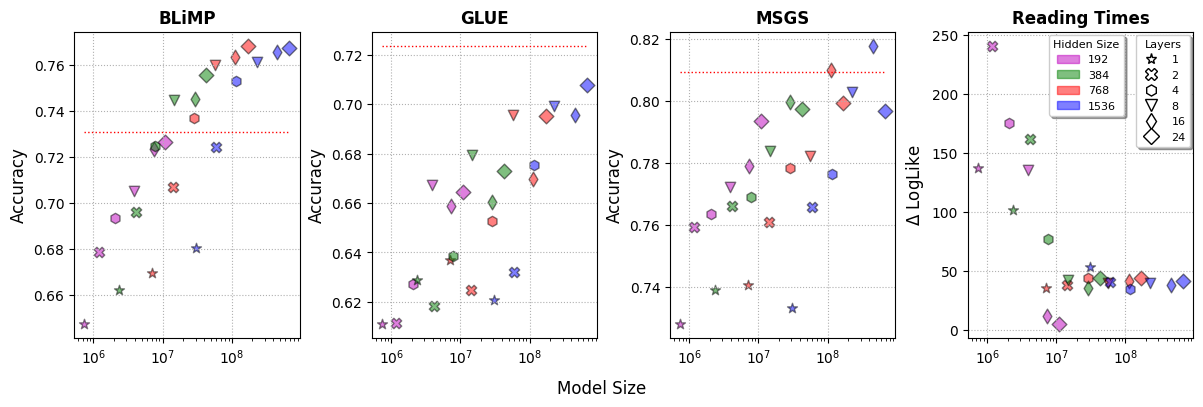

In [38]:
# legend
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

handles = []
for nlayers in df_all["layers"].unique():
    handle = mlines.Line2D([], [], marker=nlayers2marker[str(nlayers)], linestyle="None", markersize=8, 
                           markerfacecolor="white", label=nlayers, color="black")
    handles.append(handle)

fig_acc_by_size.legend(
    handles=handles, bbox_to_anchor=(0.995, 0.93), fontsize=8,       
    loc="upper right", ncol=1, fancybox=True, shadow=True,
    title="Layers", title_fontsize=8
)

handles = []
for hs in df_all["hidden_size"].unique():
    handle = mpatches.Patch(color=hs2color[str(hs)], label=hs, alpha=0.5)
    handles.append(handle)

fig_acc_by_size.legend(
    handles=handles, bbox_to_anchor=(0.94, 0.93), fontsize=8, 
    loc="upper right", ncol=1, fancybox=True, shadow=True,
    title="Hidden Size", title_fontsize=8
)

fig_acc_by_size.savefig("../out/img/all_tasks.png", dpi=400, bbox_inches="tight")

fig_acc_by_size

## All vs. BLiMP

In [39]:
df_glue_avg = df_glue.groupby(by=["config_short", "num_params", "hidden_size", "layers"])["accuracy"].mean().reset_index()
df_glue_avg = df_glue_avg.rename({"accuracy": "accuracy_glue"}, axis=1)
df_blimp_avg = df_blimp.groupby(by=["config_short", "num_params", "hidden_size", "layers"])["accuracy"].mean().reset_index()
df_blimp_avg = df_blimp_avg.rename({"accuracy": "accuracy_blimp"}, axis=1)
df_msgs_avg = df_msgs.groupby(by=["config_short", "num_params", "hidden_size", "layers"])["accuracy"].mean().reset_index()
df_msgs_avg = df_msgs_avg.rename({"accuracy": "accuracy_msgs"}, axis=1)
df_comb_avg = pd.merge(df_blimp_avg, df_glue_avg, on=["config_short", "num_params", "hidden_size", "layers"], how="left")
df_comb_avg = pd.merge(df_comb_avg, df_msgs_avg, on=["config_short", "num_params", "hidden_size", "layers"], how="left")
print(df_comb_avg)

   config_short  num_params  hidden_size  layers  accuracy_blimp  \
0        1*1536    30693888         1536       1        0.680493   
1         1*192      740160          192       1        0.647210   
2         1*384     2365056          384       1        0.662121   
3         1*768     7089408          768       1        0.669392   
4       16*1536   455666688         1536      16        0.765879   
5        16*192     7413120          192      16        0.723609   
6        16*384    28982016          384      16        0.745417   
7        16*768   113407488          768      16        0.763422   
8        2*1536    59025408         1536       2        0.724586   
9         2*192     1185024          192       2        0.678650   
10        2*384     4139520          384       2        0.696151   
11        2*768    14177280          768       2        0.707095   
12      24*1536   682318848         1536      24        0.767540   
13       24*192    10972032          192      24

In [64]:
import matplotlib.pylab as pylab
params = {
         'xtick.labelsize':10,
         'ytick.labelsize':10}
pylab.rcParams.update(params)

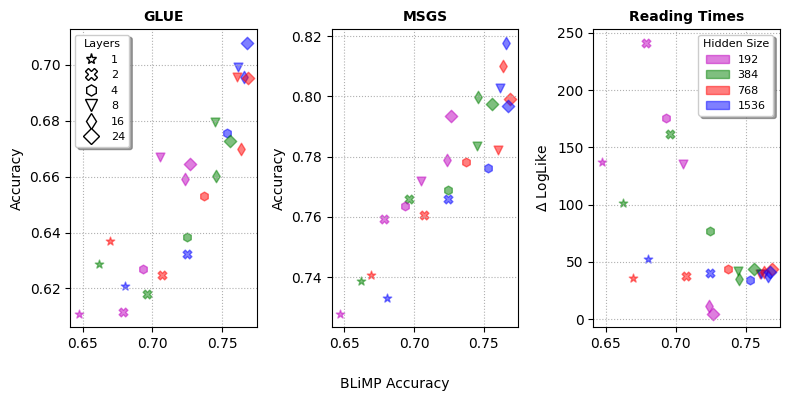

In [73]:
fig_blimp_vs_others, (ax_glue, ax_msgs, ax_rts) = plt.subplots(
    nrows=1, 
    ncols=3, 
    # sharey=True,
    sharex=True, 
    figsize=(8, 4)
)

for config in df_glue["config_short"].unique():
    # print(config)
    blimp_acc = df_comb_avg[df_comb_avg["config_short"]==config]["accuracy_blimp"].item()
    glue_acc = df_comb_avg[df_comb_avg["config_short"]==config]["accuracy_glue"].item()
    msgs_acc = df_comb_avg[df_comb_avg["config_short"]==config]["accuracy_msgs"].item()
    dll = df_lmer[df_lmer["config_short"]==config]["delta_logLike"].item()
    num_params = df_comb_avg[df_comb_avg["config_short"]==config]["num_params"].item()
    layers = df_comb_avg[df_comb_avg["config_short"]==config]["layers"].item()
    hs = df_comb_avg[df_comb_avg["config_short"]==config]["hidden_size"].item()

    # marker_size = (num_params/1000000)+10
    marker_size = 40

    ax_glue.scatter(blimp_acc, glue_acc, s=marker_size, color=hs2color[str(hs)], marker=nlayers2marker[str(layers)], alpha=0.5)
    ax_msgs.scatter(blimp_acc, msgs_acc, s=marker_size, color=hs2color[str(hs)], marker=nlayers2marker[str(layers)], alpha=0.5)
    ax_rts.scatter(blimp_acc, dll, s=marker_size, color=hs2color[str(hs)], marker=nlayers2marker[str(layers)], alpha=0.5)

# ax_glue.set_facecolor("#D5F5E3")
# ax_msgs.set_facecolor("#D5F5E3")
# ax_rts.set_facecolor("#D5F5E3")

ax_glue.grid(axis="both", linestyle=":")
ax_msgs.grid(axis="both", linestyle=":")
ax_rts.grid(axis="both", linestyle=":")

ax_glue.set_ylabel("Accuracy", fontsize=10)
ax_msgs.set_ylabel("Accuracy", fontsize=10)
ax_rts.set_ylabel(r"$\Delta$ LogLike", fontsize=10)

ax_glue.set_title("GLUE", fontsize=10, weight="bold")
ax_msgs.set_title("MSGS", fontsize=10, weight="bold")
ax_rts.set_title(r"Reading Times", fontsize=10, weight="bold")



fig_blimp_vs_others.supxlabel("BLiMP Accuracy", fontsize=10)

# legend
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

handles = []
for nlayers in df_all["layers"].unique():
    handle = mlines.Line2D([], [], marker=nlayers2marker[str(nlayers)], linestyle="None", markersize=8, markerfacecolor="white", label=nlayers, color="black")
    handles.append(handle)

fig_blimp_vs_others.legend(
    handles=handles, bbox_to_anchor=(0.175, 0.915), fontsize=8,       
    loc="upper right", ncol=1, fancybox=True, shadow=True,
    title="Layers", title_fontsize=8
)

handles = []
for hs in df_all["hidden_size"].unique():
    handle = mpatches.Patch(color=hs2color[str(hs)], label=hs, alpha=0.5)
    handles.append(handle)

fig_blimp_vs_others.legend(
    handles=handles, bbox_to_anchor=(0.98, 0.915), fontsize=8, 
    loc="upper right", ncol=1, fancybox=True, shadow=True,
    title="Hidden Size", title_fontsize=8
)

plt.tight_layout();

fig_blimp_vs_others.savefig("../out/img/blimp_vs_others.png", dpi=400, bbox_inches="tight")

## Radar plots

In [41]:
# sort
df_blimp_avg = df_blimp_avg.sort_values(by=["layers", "hidden_size"], ascending=False)
df_glue_avg = df_glue_avg.sort_values(by=["layers", "hidden_size"], ascending=False)
df_msgs_avg = df_msgs_avg.sort_values(by=["layers", "hidden_size"], ascending=False)


In [42]:
from utils import radar_factory

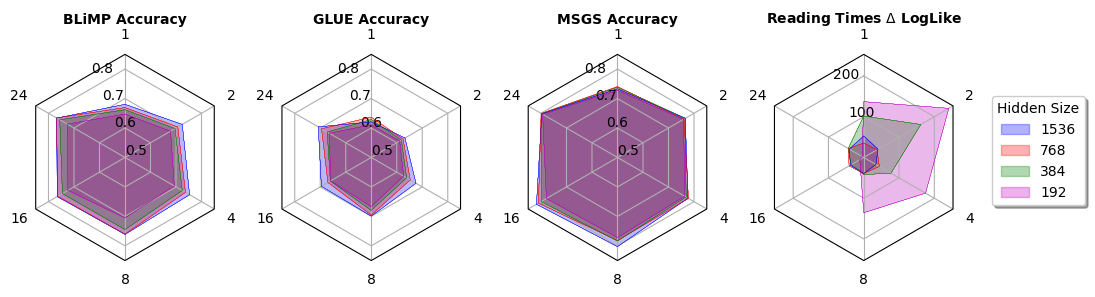

In [43]:
# BLiMP, GLUE, MSGS

layers_ordered = ["1", "24", "16", "8", "4", "2"]

theta = radar_factory(6, frame='polygon')

fig_radar, axs = plt.subplots(figsize=(10, 4), nrows=1, ncols=4, subplot_kw=dict(projection='radar'))
fig_radar.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

for i, (task, df_task) in enumerate({
    "blimp": df_blimp_avg, "glue": df_glue_avg, "msgs": df_msgs_avg}.items()):

    ax = axs[i]
    ax.set_rgrids([0.5,0.6,0.7,0.8])
    ax.set_ylim(0.5, 0.85)

    for hs in df_task["hidden_size"]:
        color = hs2color[str(hs)]
        df_hs = df_task[df_task["hidden_size"]==hs]
        accuracies = [df_hs[df_hs["layers"]==int(layers)][f"accuracy_{task}"] for layers in layers_ordered]
        ax.plot(theta, accuracies, color=color, linewidth=0.1)
        ax.fill(theta, accuracies, facecolor=color, alpha=0.05, label='_nolegend_')

    ax.set_varlabels(layers_ordered)

for i, task in enumerate(["BLiMP", "GLUE", "MSGS"]):
    axs[i].set_title(f"{task} Accuracy", weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    
# Reading times
ax = axs[3]

for hs in df_lmer["hidden_size"]:
    color = hs2color[str(hs)]
    df_hs = df_lmer[df_lmer["hidden_size"]==hs]
    dlls = [df_hs[df_hs["layers"]==int(layers)][f"delta_logLike"] for layers in layers_ordered]
    ax.plot(theta, dlls, color=color, linewidth=0.1)
    ax.fill(theta, dlls, facecolor=color, alpha=0.05, label='_nolegend_')
ax.set_varlabels(layers_ordered)
ax.set_rgrids([100, 200])
ax.set_title(r"Reading Times $\Delta$ LogLike", weight='bold', size='medium', position=(0.5, 1.1),
                horizontalalignment='center', verticalalignment='center')

# legend
handles = []
for hs in df_lmer["hidden_size"].unique():
    color = hs2color[str(hs)]
    handle = mpatches.Patch(label=hs, alpha=0.3, facecolor=color, edgecolor=color)
    handles.append(handle)

fig_radar.legend(
    handles=handles, bbox_to_anchor=(1.10, 0.67), fontsize=10, 
    loc="upper right", ncol=1, fancybox=True, shadow=True,
    title="Hidden Size", title_fontsize=10
)

plt.tight_layout();

# plt.subplots_adjust(right=0.95)

fig_radar.savefig("../out/img/radar_plots.png", dpi=400, bbox_inches="tight")

## Radar Plots for best Models

In [44]:
best_configs = ["24*768", "24*1536", "16*1536", "2*192"]

dll_norm = (df_lmer["delta_logLike"]-df_lmer["delta_logLike"].min())/(df_lmer["delta_logLike"].max()-df_lmer["delta_logLike"].min())
df_lmer_norm = copy(df_lmer)
df_lmer_norm["accuracy"] = dll_norm

dfs = {
    "blimp": df_blimp_avg.rename(columns={"accuracy_blimp": "accuracy"}),
    "glue": df_glue_avg.rename(columns={"accuracy_glue": "accuracy"}),
    "msgs": df_msgs_avg.rename(columns={"accuracy_msgs": "accuracy"}),
    "rts": df_lmer_norm
}

for task, df_task in dfs.items():
    df_task["task"] = [task for _ in range(len(df_task))]
    df_task = df_task[df_task["config_short"].isin(best_configs)]

df_best = pd.concat(dfs.values())
df_best = df_best.drop(columns=["num_params", "config", "logLike", "delta_logLike", 
                                "logLike_avg", "delta_logLike_avg", "size"])
print(df_best)


   config_short  hidden_size  layers  accuracy   task
12      24*1536         1536      24  0.767540  blimp
15       24*768          768      24  0.768596  blimp
14       24*384          384      24  0.755728  blimp
13       24*192          192      24  0.726737  blimp
4       16*1536         1536      16  0.765879  blimp
..          ...          ...     ...       ...    ...
12        2*192          192       2  1.000000    rts
9        1*1536         1536       1  0.203413    rts
20        1*768          768       1  0.130489    rts
13        1*384          384       1  0.410609    rts
17        1*192          192       1  0.559405    rts

[96 rows x 5 columns]


In [45]:
config2color = {
    '16*1536': "b", 
    '2*192': "r", 
    '24*1536': "g", 
    '24*768': "m",
}

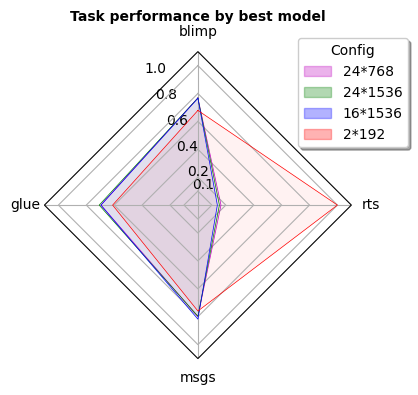

In [47]:
fig_radar_tasks, ax = plt.subplots(figsize=(4, 4), nrows=1, ncols=1, subplot_kw=dict(projection='radar'))
fig_radar_tasks.subplots_adjust(wspace=0.25, hspace=0.20, top=0.95, bottom=0.05)

theta = radar_factory(4, frame='polygon')

ax.set_rgrids([0.1,0.2,0.4,0.6,0.8,1.0])
ax.set_ylim(0.0, 1.10)

for config in best_configs:
    color = config2color[config]
    df_config = df_best[df_best["config_short"]==config]
    ax.plot(theta, df_config["accuracy"], color=color, linewidth=0.5)
    ax.fill(theta, df_config["accuracy"], facecolor=color, alpha=0.05, label='_nolegend_')
ax.set_varlabels(df_best["task"].unique())

ax.set_title(r"Task performance by best model", weight='bold', size='medium', position=(0.5, 1.3),
                horizontalalignment='center', verticalalignment='center')


# legend
handles = []
for config in best_configs:
    color = config2color[config]
    handle = mpatches.Patch(label=config, alpha=0.3, facecolor=color, edgecolor=color)
    handles.append(handle)

fig_radar_tasks.legend(
    handles=handles, bbox_to_anchor=(1.05, 0.915), fontsize=10, 
    loc="upper right", ncol=1, fancybox=True, shadow=True,
    title="Config", title_fontsize=10,
)
plt.tight_layout();

fig_radar_tasks.savefig("../out/img/radar_plot_tasks.png", dpi=400, bbox_inches="tight")

## Intermediate checkpoints

In [48]:
#babylm data
LMER_RESULTS_DIR="../lmer/filtered"

In [49]:
checkpoints = ["500", "1000", "2000", "3000", "1"]

configs = ['4*192' '2*768' '4*384' '8*192' '24*192' '1*1536' '16*192' '2*1536'
 '2*192' '1*384' '4*768' '24*1536' '16*1536' '1*192' '2*384' '1*768'
 '4*1536' '8*1536']

In [50]:
dfs = []

for i, checkpoint in enumerate(checkpoints):
    lmer_results_path = os.path.join(LMER_RESULTS_DIR, checkpoint, "lmer_results_all.tsv")
    df_checkpoint = pd.read_csv(lmer_results_path, sep="\t")
    df_checkpoint["checkpoint"] = [checkpoint for _ in range(len(df_checkpoint))]
    dfs.append(df_checkpoint)

df_checkpoints_babylm = pd.concat(dfs)

In [51]:
df_checkpoints_babylm["hidden_size"] = df_checkpoints_babylm["config"].str.split("_").str[2].apply(pd.to_numeric)
df_checkpoints_babylm["layers"] = df_checkpoints_babylm["config"].str.split("_").str[1].apply(pd.to_numeric)
df_checkpoints_babylm["config_short"] = df_checkpoints_babylm["layers"].astype(str) + "*" + df_checkpoints_babylm["hidden_size"].astype(str)
df_checkpoints_babylm["num_params"] = [config2size[config_short] for config_short in df_checkpoints_babylm["config_short"]]

In [52]:
df_5 = copy(df_lmer)
df_5["checkpoint"] = ["5" for _ in range(len(df_5))]
df_5 = df_5[df_5["config_short"].isin(df_checkpoints_babylm["config_short"].unique())]
df_checkpoints_babylm = pd.concat([df_checkpoints_babylm, df_5])
dfs.append(df_5)
checkpoints += ["5"]

In [53]:
df_checkpoints_babylm = df_checkpoints_babylm.sort_values(by=["layers", "hidden_size"], ascending=True)

In [54]:
# wikitext
LMER_RESULTS_DIR="../lmer/wikitext"

In [55]:
dfs = []

for i, checkpoint in enumerate(checkpoints):
    lmer_results_path = os.path.join(LMER_RESULTS_DIR, checkpoint, "lmer_results_all.tsv")
    df_checkpoint = pd.read_csv(lmer_results_path, sep="\t")
    df_checkpoint["checkpoint"] = [checkpoint for _ in range(len(df_checkpoint))]
    dfs.append(df_checkpoint)

df_checkpoints_wiki = pd.concat(dfs)

In [56]:
df_checkpoints_wiki["hidden_size"] = df_checkpoints_wiki["config"].str.split("_").str[2].apply(pd.to_numeric)
df_checkpoints_wiki["layers"] = df_checkpoints_wiki["config"].str.split("_").str[1].apply(pd.to_numeric)
df_checkpoints_wiki["config_short"] = df_checkpoints_wiki["layers"].astype(str) + "*" + df_checkpoints_wiki["hidden_size"].astype(str)
df_checkpoints_wiki["num_params"] = [config2size[config_short] for config_short in df_checkpoints_wiki["config_short"]]

In [57]:
df_checkpoints_wiki = df_checkpoints_wiki.sort_values(by=["layers", "hidden_size"], ascending=True)

In [58]:
import matplotlib.pylab as pylab
params = {
         'xtick.labelsize':12,
         'ytick.labelsize':12}
pylab.rcParams.update(params)

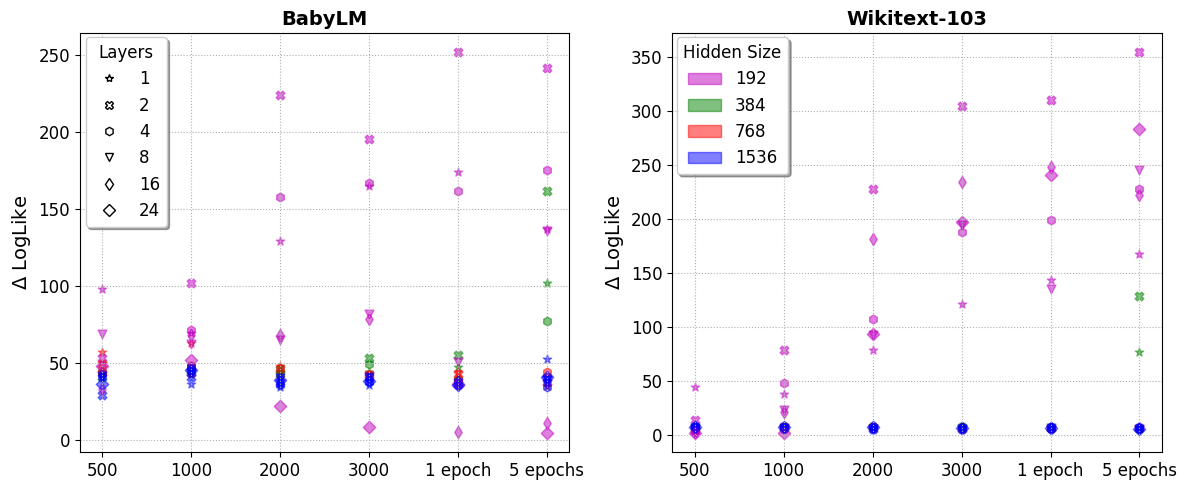

In [59]:
# fig_more_steps = plt.figure(figsize=(5,4))
# ax = fig_more_steps.add_subplot(111)

fig_more_steps, (ax_babylm, ax_wikitext) = plt.subplots(
    nrows=1, 
    ncols=2, 
    # sharey=True,
    sharex=True, 
    figsize=(12, 5)
)

xs = range(len(checkpoints))

ax = ax_babylm

for x, checkpoint in enumerate(checkpoints):
    df_config = df_checkpoints_babylm[df_checkpoints_babylm["checkpoint"]==checkpoint]
    for config, dll in zip(df_config["config_short"], df_config["delta_logLike"]):
        # print(x, checkpoint, config)
        layers, hs = config.split("*")[0], config.split("*")[1]
        ax.scatter(x, dll, s=40, marker=nlayers2marker[layers], color=hs2color[str(hs)], alpha=0.5)

ax.set_xticks(xs, labels=["500", "1000", "2000", "3000", "1 epoch", "5 epochs"], fontsize=12)
ax.grid(axis="both", linestyle=":")

ax.set_ylabel(r"$\Delta$ LogLike", fontsize=14)

ax.set_title("BabyLM", weight="bold", fontsize=14)

ax = ax_wikitext

for x, checkpoint in enumerate(checkpoints):
    df_config = df_checkpoints_wiki[df_checkpoints_wiki["checkpoint"]==checkpoint]
    for config, dll in zip(df_config["config_short"], df_config["delta_logLike"]):
        # print(x, checkpoint, config)
        layers, hs = config.split("*")[0], config.split("*")[1]
        ax.scatter(x, dll, s=40, marker=nlayers2marker[layers], color=hs2color[str(hs)], alpha=0.5)

ax.set_xticks(xs, labels=["500", "1000", "2000", "3000", "1 epoch", "5 epochs"], fontsize=12)
ax.grid(axis="both", linestyle=":")

ax.set_ylabel(r"$\Delta$ LogLike", fontsize=14)

ax.set_title("Wikitext-103", weight="bold", fontsize=14)

ax = ax_wikitext

# legend
handles = []
for nlayers in df_all["layers"].unique():
    handle = mlines.Line2D([], [], marker=nlayers2marker[str(nlayers)], linestyle="None", markersize=6, markerfacecolor="white", label=nlayers, color="black")
    handles.append(handle)

fig_more_steps.legend(
    handles=handles, bbox_to_anchor=(0.15, 0.932), fontsize=12,       
    loc="upper right", ncol=1, fancybox=True, shadow=True,
    title="Layers", title_fontsize=12
)

handles = []
for hs in df_all["hidden_size"].unique():
    handle = mpatches.Patch(color=hs2color[str(hs)], label=hs, alpha=0.5)
    handles.append(handle)

fig_more_steps.legend(
    handles=handles, bbox_to_anchor=(0.668, 0.932), fontsize=12, 
    loc="upper right", ncol=1, fancybox=True, shadow=True,
    title="Hidden Size", title_fontsize=12
)

plt.tight_layout();

plt.savefig("../out/img/rts_more_steps.png", dpi=400, bbox_inches="tight")